# Dataset preparation from raw images

##### This notebook uses patching function from AxonDeepSeg software. You need to download and install it in order to use this notebook. 

In [ ]:
cd /Users/username/axondeepseg

In [6]:
from AxonDeepSeg.data_management import dataset_building
import os, shutil
import numpy as np
from __future__ import print_function
import cv2
from matplotlib import pyplot as plt
from skimage import io, img_as_uint, img_as_ubyte
from scipy.misc import imread, imsave
import imageio
import random

### STEP 1: GENERATE THE PATCHES FROM RAW IMAGES.


---
##### The folder structure *before* the patching:

* ***folder_of_your_raw_data***

     * **sample1**
          * *image.png*
          * *mask.png*
          * *pixel_size_in_micrometer.txt*
     * **sample2**
          * *image.png*
          * *mask.png*
          * *pixel_size_in_micrometer.txt*
            
            ...
            
     * **sample6**
          * *image.png*
          * *mask.png*
          * *pixel_size_in_micrometer.txt*
            
---
#### The folder structure *after* the patching:

* ***folder_of_your_raw_data***

    * **sample1**
       * *image_0.png*
       * *image_1.png*
       * *image_2.png*
       * ...
            
       * *mask_0.png*
       * *mask_1.png*
       * *mask_2.png*
       * ...
     
    * **sample2**
       * *image_0.png*
       * *image_1.png*
       * *image_2.png*
       * ...
           
       * *mask_0.png*
       * *mask_1.png*
       * *mask_2.png*
       * ...
            
    * **sample6**
       * *image_0.png*
       * *image_1.png*
       * *image_2.png*
       * ...
            
       * *mask_0.png*
       * *mask_1.png*
       * *mask_2.png*
       * ...
---
### Define the parameters for the patch extraction.

* **path_raw_data**: Path of the folder that contains the raw data. Each labelled sample of the dataset should be in a different subfolder. For each sample (and subfolder), the expected files are the following:
    * *"image.png"*: The microscopy sample image (uint8 format).
    * *"mask.png"*: The microscopy sample image (uint8 format).
    * *"pixel_size_in_micrometer.txt"*: A one-line text file with the value of the pixel size of the sample. For instance, if the pixel size of the sample is 0.02um, the value in the text file should be **"0.02"**.
    
* **path_patched_data**: Path of the folder that will contain the raw data divided into patches. Each sample (i.e. subfolder) of the raw dataset will be divided into patches and saved in this folder. For instance, if a sample of the original data is divided into 10 patches, the corresponding folder in the **path_patched_dataset** will contain 10 image and mask patches, named **image_0.png** to **image_9.png** and **mask_0.png** to **mask_9.png**, respectively. 

* **patch_size**: The size of the patches in pixels. For instance, a patch size of **128** means that each generated patch will be 128x128 pixels.

* **general_pixel_size**: The pixel size (i.e. resolution) of the generated patches in micrometers. The pixel size will be the same for all generated patches. If the selected pixel size is different from the native pixel sizes of the samples, downsampling or upsampling will be performed. Note that the pixel size should be chosen by taking into account the modality of the dataset and the patch size. 
---

In [ ]:
cd ~

In [30]:
# Define the input path to the samples, output path for the patches and path to final dataset

path_raw_data_train = './Documents/data/SEM'
path_patched_data_train = './Documents/data/SEM_test'
path_dataset = './Documents/data/SEM_dataset'

patch_size = 512
general_pixel_size = 0.2

In [15]:
# Split the *Train* dataset into patches
dataset_building.raw_img_to_patches(path_raw_data_train, path_patched_data_train, thresh_indices = [0, 0.2, 0.8], 
                                    patch_size = patch_size, resampling_resolution = general_pixel_size)



100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


### STEP 2: CONCATENATE PATCHES OF 1 IMAGE TO NUMPY ARRAY
---
##### 1. Extract Myelin Mask form 3-class masks (Myelin-Axon_Background) 
* The masks we have in our dataset are 3 class masks (Myelin, Axon, Background). 
* For this project, we need to extract only myelin class to do binary segmentation
* This is done with *get_myelin_mask()* function

##### 2. Concatenate all the patches of 1 image into two normalized numpy-arrays (images and masks)
* Read patches of 1 image from data directory and convert them to numpy-array with chosen dimensions
* Concatenate the numpy-arrays
* Save it to the directory under *output_path_image.npy* or *output_path_mask.npy*
* This is done with *create_data()* function

     
---

In [17]:
def get_myelin_mask(mask_folder_path):
    """
    Extract myelin mask from 3-class mask using thresholding
    :param mask_folder_path: path to folder containing the masks
    :output: write new masks to the folder
    """
    for f in os.listdir(mask_folder_path):
        if not f.startswith('.'):
            if f[:4] == "mask":
    #             print(f)
                mask = imageio.imread(os.path.join(mask_folder_path, f))
                myelin = (mask > 1) & (mask < 199)
                myelin = myelin.astype(int)
                myelin = np.array(myelin, dtype = np.uint8)
                # save the masks
                imageio.imwrite(os.path.join(mask_folder_path, "myelin_" + str(f[:-4]) + '.png'), myelin.astype(int))
                
                

def create_data(data_path, output_path, patch_size):
    """
    Generate numpy arrays data form patches and save them to the project path
    :param data_path: path to patched images
    :param output_path: path to output folder
    :param patch_size: patch size to dimension the numpy arrays
    :return: output_path_image.npy and output_path_mask.npy
    """
    image_rows = patch_size
    image_cols = patch_size
    
    imgs = np.zeros((1, patch_size, patch_size))
    imgs_mask = np.zeros((1, patch_size, patch_size))
    
    for f in os.listdir(data_path):
        if not f.startswith('.'):
#         print(f)
            if f[:4] == "imag":
                img = imageio.imread(os.path.join(data_path, f))
                img =  np.expand_dims(img, axis=0)
                imgs = np.append(imgs, img, axis = 0)
            if f[:4] == "myel":
                mask = imageio.imread(os.path.join(data_path, f))
                mask =  np.expand_dims(mask, axis=0)
                imgs_mask = np.append(imgs_mask, mask, axis = 0)
        
    path_images = output_path + '_image'
    path_masks = output_path + '_mask' 
    
    print(imgs[1:].shape, " images, ", imgs_mask[1:].shape, " masks.")

    np.save(path_images, imgs[1:].astype(np.uint8))
    np.save(path_masks, imgs_mask[1:].astype(np.uint8))




In [18]:
for f in os.listdir(path_patched_data_train):
    path = os.path.join(path_patched_data_train, f)
    output_path = os.path.join(path_patched_data_train, f)
    print(path)
    # extract myelin masks from 3-class masks
    get_myelin_mask(path)
    # concatenate patchces to numpy array
    create_data(path, output_path, patch_size)
    

./Documents/data/SEM_test/data2


(4, 512, 512)  images,  (4, 512, 512)  masks.
./Documents/data/SEM_test/data3


(4, 512, 512)  images,  (4, 512, 512)  masks.
./Documents/data/SEM_test/data4


(4, 512, 512)  images,  (4, 512, 512)  masks.


### STEP 3: CREATE DATASET - UNIFORM REPARTITION OF IMAGES.
---
##### 1. Join all patches from all images into 1  unique numpy array
* Each images are cut into multiple patches, assembled in their respective numpy-array
* These multiple numpy-array(1 per sample) are then stacked to create 1 dataset.
* This is done for the images and the masks. 

##### 2. The patches are then shuffled to obtain a uniform distribution of samples accross the dataset. 
* To have a fair train/validation/test splitting later on, we ditribute the patches of each samples uniformly across the dataset. 
*
---

In [38]:
# initialize empty arrays
imgs = np.zeros((0, patch_size, patch_size))
imgs_mask = np.zeros((0, patch_size, patch_size))

for f in os.listdir(path_patched_data_train):
    if f[-9:] == "image.npy":
        print(f)
        img = np.load(os.path.join(path_patched_data_train, f))
        imgs = np.vstack((imgs, img))
    if f[-8:] == "mask.npy":
        print(f)
        mask = np.load(os.path.join(path_patched_data_train, f))
        imgs_mask = np.vstack((imgs_mask, mask))

random_serie = random.sample(range(imgs.shape[0]), imgs.shape[0])

shuffled_imgs = np.asarray(imgs[random_serie])
shuffled_imgs =  np.expand_dims(shuffled_imgs, axis=1)
shuffled_imgs_mask = np.asarray(imgs_mask[random_serie])
shuffled_imgs_mask =  np.expand_dims(shuffled_imgs_mask, axis=1)

print("images dimensions= ", np.asarray(shuffled_imgs).shape)
print("masks dimensions= ",np.asarray(shuffled_imgs_mask).shape)

np.save(os.path.join(path_dataset ,  "image.npy"), shuffled_imgs)
np.save(os.path.join(path_dataset , "mask.npy"), shuffled_imgs_mask)

data2_image.npy
data2_mask.npy
data3_image.npy
data3_mask.npy
data4_image.npy
data4_mask.npy
images dimensions=  (12, 1, 512, 512)
masks dimensions=  (12, 1, 512, 512)


### STEP 4:  DATASET INTEGRITY VERIFICATION
---
##### 1. Load the numpy arrays and check dimensions

##### 2. Visally check correspondance between image and mask


In [42]:
img = np.load(os.path.join(path_dataset, "image.npy"))
mask = np.load(os.path.join(path_dataset, "mask.npy"))

In [43]:
print(img.shape)
print(mask.shape)

(12, 1, 512, 512)
(12, 1, 512, 512)


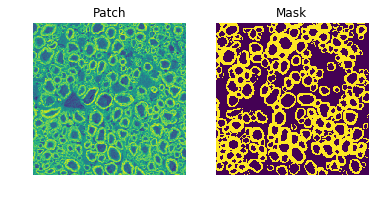

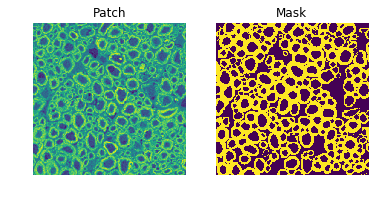

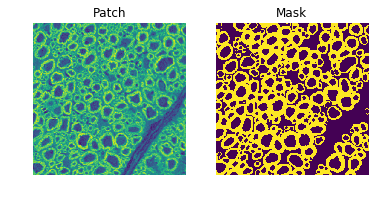

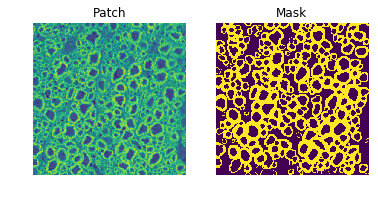

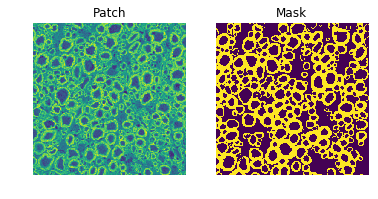

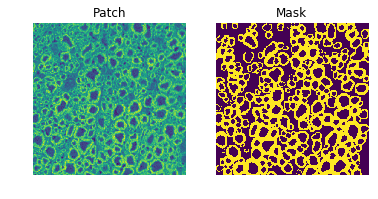

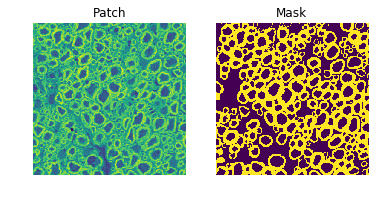

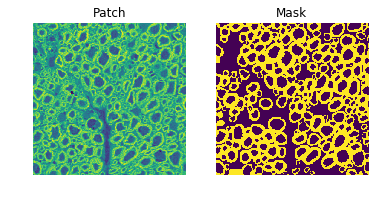

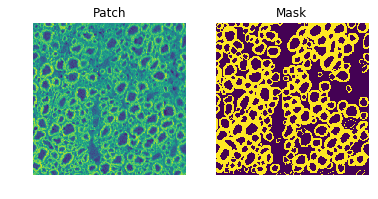

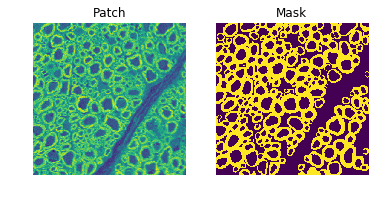

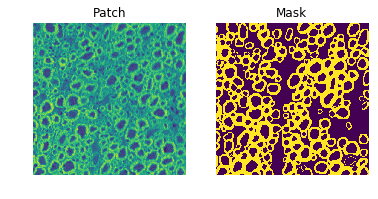

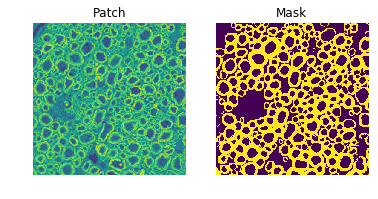

In [46]:
# plot patches and corresponding masks 
for i in range(len(img)):
    plt.subplot(121)
    plt.title("Patch")
    plt.imshow(img[i,0, :, :])
    plt.axis('off')
    plt.subplot(122)
    plt.title("Mask")
    plt.imshow(mask[i,0, :, :])
    plt.axis('off')
    plt.show()